##### create model

In [1]:
from fastai.text import *
import warnings; warnings.simplefilter('ignore')

In [2]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [3]:
#[edited] copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device)
        return self.drop(self.embed(inp.long()) * math.sqrt(self.emb_sz) + self.pos_enc(pos.float()))

In [4]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb
def feed_forward(d_model, d_ff, ff_p=0., double_drop=True):
    layers = [nn.Linear(d_model, d_ff), nn.ReLU()]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

In [5]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, d_head=None, p=0., bias=True, scale=True):
        super().__init__()
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.q_wgt,self.k_wgt,self.v_wgt = [nn.Linear(
            d_model, n_heads * d_head, bias=bias) for o in range(3)]
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(p),nn.Dropout(p)
        self.ln = nn.LayerNorm(d_model)
        
    def forward(self, q, kv, mask=None):
        return self.ln(q + self.drop_res(self.out(self._apply_attention(q, kv, mask=mask))))
    
    def create_attn_mat(self, x, layer, bs):
        return layer(x).view(bs, x.size(1), self.n_heads, self.d_head
                            ).permute(0, 2, 1, 3)
    
    def _apply_attention(self, q, kv, mask=None):
        bs,seq_len = q.size(0),q.size(1)
        wq,wk,wv = map(lambda o: self.create_attn_mat(*o,bs),
                       zip((q,kv,kv),(self.q_wgt,self.k_wgt,self.v_wgt)))
        attn_score = wq @ wk.transpose(2,3)
        if self.scale: attn_score /= math.sqrt(self.d_head)
        if mask is not None: 
            attn_score = attn_score.float().masked_fill(mask, -float('inf')).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = attn_prob @ wv
        return attn_vec.permute(0, 2, 1, 3).contiguous().view(bs, seq_len, -1)

In [6]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
def get_output_mask(inp):
    return torch.triu(inp.new_ones(inp.size(1),inp.size(1)), diagonal=1)[None,None].byte()

In [7]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
class EncoderBlock(nn.Module):
    "Encoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff  = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, mask=None): return self.ff(self.mha(x, x, mask=mask))

In [8]:
# copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
class DecoderBlock(nn.Module):
    "Decoder block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads, d_model, d_head, d_inner, p=0., bias=True, scale=True, double_drop=True):
        super().__init__()
        self.mha1 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.mha2 = MultiHeadAttention(n_heads, d_model, d_head, p=p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=p, double_drop=double_drop)
    
    def forward(self, x, enc, mask_out=None): return self.ff(self.mha2(self.mha1(x, x, mask_out), enc))

In [9]:
# [edited] copy from https://github.com/fastai/course-nlp/blob/master/8-translation-transformer.ipynb 
class Model(Module):
    def __init__(self, inp_vsz, out_vsz, n_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=0):
        self.enc_emb = TransformerEmbedding(inp_vsz, d_model, p)
        self.dec_emb = TransformerEmbedding(out_vsz, d_model, 0.)
        args = (n_heads, d_model, d_head, d_inner, p, bias, scale, double_drop)
        self.encoder = nn.ModuleList([EncoderBlock(*args) for _ in range(n_layers)])
        self.decoder = nn.ModuleList([DecoderBlock(*args) for _ in range(n_layers)])
        self.out = nn.Linear(d_model, out_vsz)
        self.out.weight = self.dec_emb.embed.weight
        self.criterion = CrossEntropyFlat(ignore_index=0)
        
    def predict(self, inp, out, mask=True):
        mask_out = get_output_mask(out) if mask else None
        enc,out = self.enc_emb(inp),self.dec_emb(out)
        enc = compose(self.encoder)(enc)
        out = compose(self.decoder)(out, enc, mask_out)
        return self.out(out)
    
    def loss(self, pred, en_ans):
        batch_size, length = en_ans.shape[0], en_ans.shape[1]
        # train data:   eg. [BOS] I am a ... [EOS] [PAD]
        # ground truth: eg. I am a ... [EOS] [PAD] [PAD]
        with torch.no_grad():
            accuracy = float(torch.sum((pred.argmax(dim=2)==en_ans) * (en_ans!=0)))/float(torch.sum(en_ans!=0))
       
        loss = self.criterion(pred, en_ans)
        return loss, accuracy
    
    def forward(self, ja_seq, en_seq, en_ans):
        pred = self.predict(ja_seq, en_seq)
        return self.loss(pred, en_ans)

In [10]:
def get_param(*,cuda_optim=False,n_layers=6,n_heads=8,d_model=256,d_head=32,d_inner=1024,
              drop=0.1,bias=True,scale=True,double_drop=True,lrate_coef=1,warmup_steps=4000):
    return {'cuda_optim':cuda_optim, 'n_layers':n_layers, 'n_heads':n_heads, 'd_model':d_model, 'd_head':d_head,
            'd_inner':d_inner, 'drop':drop, 'bias':bias, 'scale':scale, 'double_drop':double_drop,
            'lrate_coef':lrate_coef, 'warmup_steps':warmup_steps }

In [11]:
def get_elms(params, device:str, ja_dicsize, en_dicsize, model=None):
    torch.backends.cudnn.benchmark = params['cuda_optim']
    if model is None:
        model = Model(ja_dicsize, en_dicsize, n_layers=params['n_layers'], n_heads=params['n_heads'], 
                      d_model=params['d_model'], d_head=params['d_head'], d_inner=params['d_inner'], 
                      p=params['drop'], bias=params['bias'], scale=params['scale'], double_drop=params['double_drop']).to(torch.float)
    optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), eps=1e-09)
    lrate_lambda = lambda step_num: params['d_model']**(-0.5)*params['lrate_coef']*min((step_num+1)**(-0.5), (step_num+1)*params['warmup_steps']**(-1.5))
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=[lrate_lambda])
    device = torch.device(device if torch.cuda.is_available() else "cpu")
    print(device)
    print(sum(p.numel() for p in model.parameters()))
    return model, optimizer, scheduler, device

In [12]:
if __name__ == '__main__':
    !jupyter nbconvert --to python fastai_model.ipynb

[NbConvertApp] Converting notebook fastai_model.ipynb to python
[NbConvertApp] Writing 9798 bytes to fastai_model.py


----
----

In [1]:
if __name__ == '__main__':
    from Chapter10_91 import Translator, DataSet, EarlyStopping, Print, Save, Tensorboard, BleuCallback, Trainer
    from fastai_model import get_param, get_elms
    import torch
    import torch.optim as optim

In [2]:
if __name__ == '__main__':
    import pickle
    with open('model_logs/ja_dic.pickle', 'rb') as f: ja_dic = pickle.load(f)
    with open('model_logs/en_dic.pickle', 'rb') as f: en_dic = pickle.load(f)
    ja_dicsize = max(ja_dic.values())+1
    en_dicsize = max(en_dic.values())+1
    print(ja_dicsize, en_dicsize)

23767 20176


In [3]:
if __name__ == '__main__':
    batch_size = 64*2
    lrate_coef =  25000/batch_size
    params = get_param(d_model=512, lrate_coef=lrate_coef)
    model, optimizer, scheduler, device = get_elms(params, 'cuda:9', ja_dicsize, en_dicsize)

cuda:9
44611280


In [4]:
if __name__ == '__main__':
    translator = Translator(ja_dic, en_dic)
    trainset = DataSet("train", maxlength=60, pathkey="ids")
    devset = DataSet("dev", maxlength=60, pathkey="ids")

In [5]:
if __name__ == '__main__':
    from string import ascii_letters
    from random import choices
    examples = ["私以外私じゃないの", "私は猫です。", "日本の水墨画を一変させた。"]
    
    bleu_cb = BleuCallback(lambda seq: " ".join([translator.en_dic_rev[s] if s!=12 else ''.join(choices(ascii_letters,k=5)) for s in seq]))
    es_cb = EarlyStopping(count=10)
    save_cb = Save(model,'model_logs/fastai/')
    tb_cb = Tensorboard('./tb_logs/', 'fastai', bleu_cb)
    print_cb = Print(model, translator, device, examples=examples, early_stopping=es_cb, bleu_callback=bleu_cb)
    callbacks = [es_cb,bleu_cb,save_cb,tb_cb,print_cb]

savedir:model_logs/fastai_20200804_140519
tensorboard tagname: 20200804_140521_fastai


In [6]:
if __name__ == '__main__':
    trainer = Trainer(translator, trainset, devset, device=device)
    trainer.run(model, optimizer, epoch=300, device=device, batch_size=batch_size, shuffle=True, scheduler=scheduler, callbacks=callbacks)

>10[  1/300]epoch: loss: 5.7504896, 4.4247640 | acc: 22.23026%, 31.50379% | bleu: 3.69683
   私以外私じゃないの　　　　	[UNK] [UNK] [UNK] no no no no no no no no no no [UNK] no no no no no no no no no no no
   私は猫です。　　　　　　　	[UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] . [EOS]
   日本の水墨画を一変させた。	In Japan Japan Japan [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] [UNK] . [EOS]
>10[  2/300]epoch: loss: 3.6574278, 3.3536151 | acc: 38.76648%, 41.28869% | bleu: 8.28098
   私以外私じゃないの　　　　	I I I I I I I you you you you you you you you you you you you you you you you you you
   私は猫です。　　　　　　　	I I I I I I I I I I I I I I I I I I I I I I I I I
   日本の水墨画を一変させた。	The Japanese - painting painting painting of Japanese painting painting was changed to [UNK] [UNK] . [EOS]
>10[  3/300]epoch: loss: 2.9297309, 2.9189712 | acc: 46.61794%, 46.24513% | bleu: 13.04202
   私以外私じゃないの　　　　	I do do do do not do do do do do do do do do do do do do do do do do do do
   私は猫です。　　　

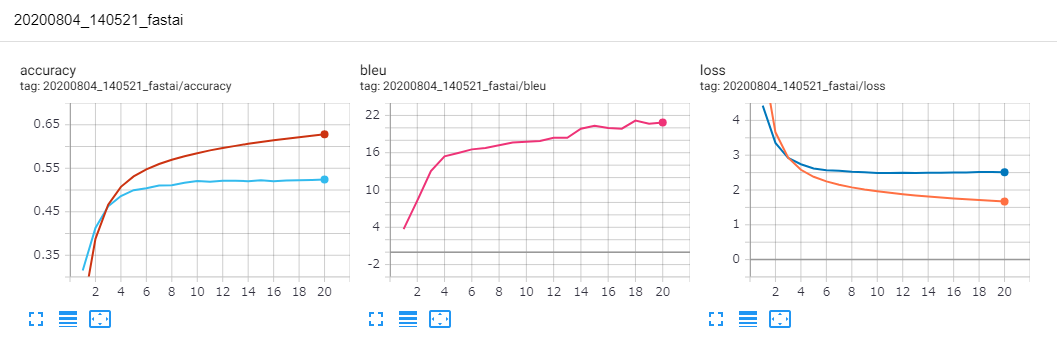

In [1]:
from IPython.display import Image
Image("imgs/20200804_140521_fastai.png")